# Data Exploration

### Client information

|Name|Type|Requirements|
|---|---|---|
|Zachary Brooks| Seller| Invests in historical houses, best neighborhoods, high profits, best timing within a year, should renovate?|


### Hypotheses

|#|Hypothesis|
|---|---|
|1|Big living footage and high grades increase houses prices|
|2|The best timing within a year for selling would be spring or summer|
|3|Renovation would increase the profit a lot|

### Insights

|#|Insights|
|---|---|
|1|Historical houses are mainly loacted left of Lake Washington|
|2|Grade, view and living footage increase the price but lot footage does not|
|3|More houses have been sold in spring and summer than in the winter|

### Requirements as Pseudocode

|Requirement|Pseudocode|Reference|
|---|---|---|
|Historical house|Year of construction is either before 1949 or 1924|https://www.homeday.de/de/immobilienkauf/altes-haus-kaufen/|
|Best neighborhoods 1|Only houses where the living footage of the nearest neighbors is bigger than the 95% quartile|
|Best neighborhoods 2|ZIP codes that are given by Chat GPT which belong to good neighborhoods|
|High profits|Difference between selling and buying price should be bigger than the third quartile depended on averages on seasons for historical houses in good neighborhoods|
|Best timing of the year|Similar to high profit|


### Initialization

In [2]:
# Import packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import requests
from scipy.stats import ttest_ind

#Remove warnings
pd.options.mode.chained_assignment = None

# Set variables
keep_columns = ["id","condition","grade","yr_built","yr_renovated","zipcode","long","lat","sqft_living15","sqft_lot15","date","price"]

In [3]:
# Read data and keep only needed columns
df_orig  = pd.read_csv("data/eda.csv")
df_short = df_orig#[keep_columns]
df_short.head(5)

,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,sale_id,date,price
0,7129300520,3.0,1.00,1180.0,5650.0,1.0,NaN,0.0,3,7,...,1955,0.0,98178,47.5112,-122.257,1340.0,5650.0,1,2014-10-13,221900.0
1,6414100192,3.0,2.25,2570.0,7242.0,2.0,0.0,0.0,3,7,...,1951,19910.0,98125,47.7210,-122.319,1690.0,7639.0,2,2014-12-09,538000.0
2,5631500400,2.0,1.00,770.0,10000.0,1.0,0.0,0.0,3,6,...,1933,NaN,98028,47.7379,-122.233,2720.0,8062.0,3,2015-02-25,180000.0
3,2487200875,4.0,3.00,1960.0,5000.0,1.0,0.0,0.0,5,7,...,1965,0.0,98136,47.5208,-122.393,1360.0,5000.0,4,2014-12-09,604000.0
4,1954400510,3.0,2.00,1680.0,8080.0,1.0,0.0,0.0,3,8,...,1987,0.0,98074,47.6168,-122.045,1800.0,7503.0,5,2015-02-18,510000.0


In [4]:
# Checkout duplicates
df_short.duplicated().value_counts() # -> no duplicates

# Checkout missing values
df_short.isna().sum() # -> Only missing values in yr_renovated which is fine

# change "date" dtype to datetime with format %Y-%m-%d
df_short['date'] = pd.to_datetime(df_short['date'], format='%Y-%m-%d')

# change "yr_renovated" column to an actual year
df_short["yr_renovated"] = (df_short["yr_renovated"].fillna(0)/10).astype("int")

# Add selling month to the dataset
df_short["date_month"] = df_short['date'].dt.month

# Add renovated column which is truw for all houses that have been renovated in the last 5 years
df_short["renovated"] = df_short['date'].dt.year - df_short['yr_renovated']<3



In [5]:
df_short["yr_renovated"].unique()

array([   0, 1991, 2002, 2010, 1992, 2013, 1994, 1978, 2005, 2003, 1984,
       1954, 2014, 2011, 1983, 1945, 1990, 1988, 1977, 1981, 1995, 2000,
       1999, 1998, 1970, 1989, 2004, 1986, 2007, 1987, 2006, 1985, 2001,
       1980, 1971, 1979, 1997, 1950, 1969, 1948, 2009, 2015, 1974, 2008,
       1968, 2012, 1963, 1951, 1962, 1953, 1993, 1996, 1955, 1982, 1956,
       1940, 1976, 1946, 1975, 1964, 1973, 1957, 1959, 1960, 1967, 1965,
       1934, 1972, 1944, 1958])

### Historcial house
Year of construction is either before 1949 or 1924

In [6]:
cond_hist49 = df_short["yr_built"] <1949
cond_hist24 = df_short["yr_built"] <1924

### Best neighborhoods
1) Only houses where the living footage of the nearest neighbors is bigger than the 95% quartile


In [7]:
cond_neighbor_liv = df_short["sqft_living15"] > df_short["sqft_living15"].quantile(0.95)

2) ZIP codes that are given by Chat GPT which belong to good neighborhoods

In [8]:
zip_GPT = [98004, 98005, 98006, 98007, 98033, 98034, 98052, 98074, 98075, 98040, 98027, 98029, 98039, 98056, 98059, 98045, 98116, 98126, 98102, 98109, 98107]
cond_neighbor_zip = df_short["zipcode"].isin(zip_GPT)

In [9]:
# Add conditions to dataset
df_short["cond_neighbor_liv"] = cond_neighbor_liv
df_short["cond_neighbor_zip"] = cond_neighbor_zip

### Best profit
Difference between selling and buying price should be bigger than the third quartile depended on averages on seasons for historical houses in good neighborhoods

In [10]:
df_best = df_short[cond_hist49 & cond_neighbor_zip]
df_best

,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,long,sqft_living15,sqft_lot15,sale_id,date,price,date_month,renovated,cond_neighbor_liv,cond_neighbor_zip
14,1175000570,5.0,2.00,1810.0,4850.0,1.5,0.0,0.0,3,7,...,-122.394,1360.0,4850.0,15,2015-03-12,530000.0,3,False,False,True
36,9435300030,4.0,1.00,1660.0,34848.0,1.0,0.0,0.0,1,5,...,-122.132,2160.0,11467.0,37,2014-05-28,550000.0,5,False,False,True
37,2768000400,4.0,2.00,2360.0,6000.0,2.0,0.0,0.0,4,8,...,-122.362,1730.0,4700.0,38,2014-12-30,640000.0,12,False,False,True
77,2391600320,3.0,1.00,1040.0,5060.0,1.0,0.0,0.0,3,7,...,-122.394,890.0,5060.0,78,2015-04-20,480000.0,4,False,False,True
95,1483300570,4.0,2.50,3300.0,10250.0,1.0,0.0,0.0,3,7,...,-122.249,1950.0,6045.0,96,2014-09-08,905000.0,9,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20001,1025039168,1.0,0.75,740.0,1284.0,1.0,0.0,0.0,4,6,...,-122.406,1430.0,3988.0,20002,2014-09-23,290000.0,9,False,False,True
20077,2025049206,2.0,1.00,710.0,1131.0,2.0,0.0,0.0,4,7,...,-122.329,1370.0,1173.0,20078,2014-06-11,399950.0,6,False,False,True
20567,9151600055,4.0,2.75,2700.0,6000.0,2.0,0.0,0.0,4,8,...,-122.383,2050.0,5400.0,20568,2014-07-09,749000.0,7,False,False,True
21027,9276200220,1.0,1.00,720.0,3166.0,1.0,0.0,0.0,3,6,...,-122.389,1140.0,6250.0,21028,2014-07-17,375000.0,7,False,False,True


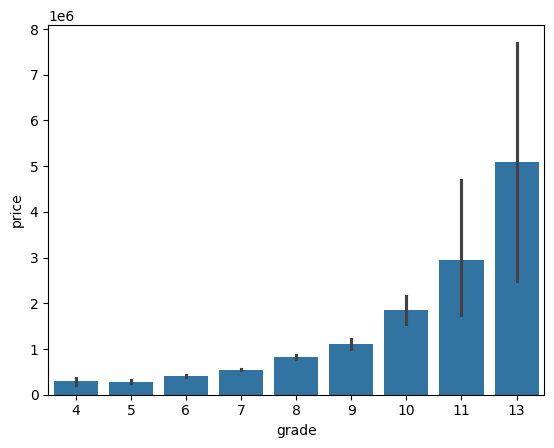

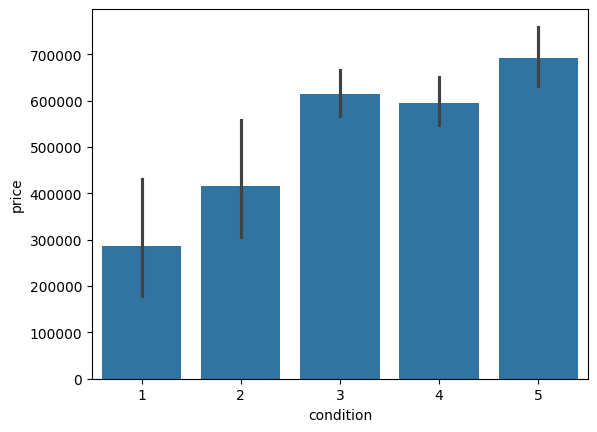

In [11]:
#Price by different variables
sns.barplot(df_best, x="grade", y="price")
plt.show()
sns.barplot(df_best, x="condition", y="price")
plt.show()


In [12]:
# Significance check that renovated houses can be sold for more money
pvalue_all = ttest_ind(df_short[df_short["renovated"]]["price"], df_short[df_short["renovated"] == False]["price"]).pvalue
pvalue_best = ttest_ind(df_best[df_best["renovated"]]["price"], df_best[df_best["renovated"] == False]["price"]).pvalue
print(f"p-value of all sold houses: {pvalue_all}")
print(f"p-value of best fitting sold houses: {pvalue_best}")

p-value of all sold houses: 4.769720794352061e-05
p-value of best fitting sold houses: 0.22187561598149153


<Axes: xlabel='sqft_lot', ylabel='price'>

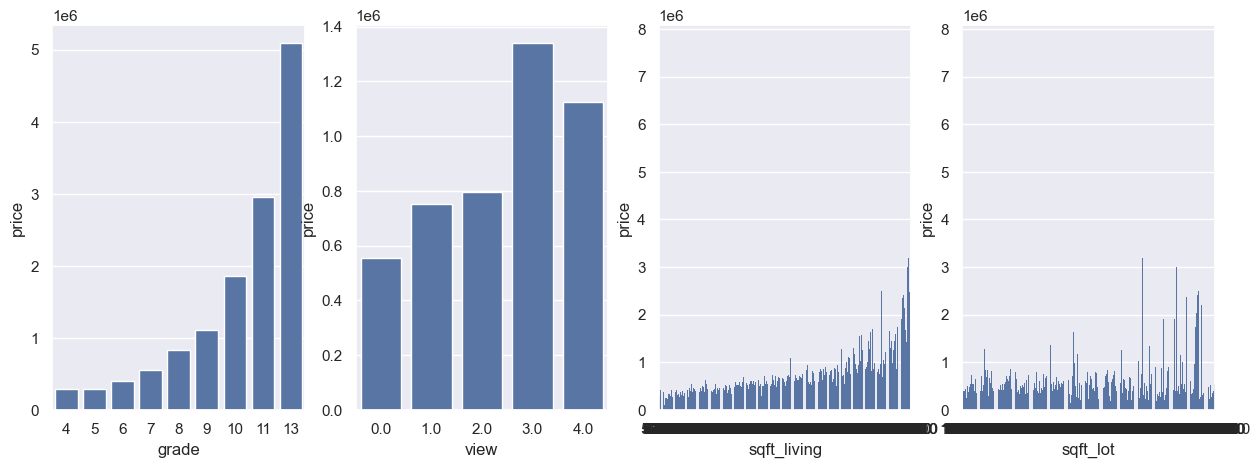

In [13]:
# Histplots for price by grade, footage and view

sns.set_theme(rc={'figure.figsize':(15,5)})
plt.subplot(1,4,1)
sns.barplot(df_best, x="grade", y="price", errorbar=None)
plt.subplot(1,4,2)
sns.barplot(df_best, x="view", y="price", errorbar=None)
plt.subplot(1,4,3)
sns.barplot(df_best, x="sqft_living", y="price", errorbar=None,lw=0)
plt.subplot(1,4,4)
sns.barplot(df_best, x="sqft_lot", y="price", errorbar=None,lw=0)

## Visualizations

Text(0, 0.5, 'Number of houses')

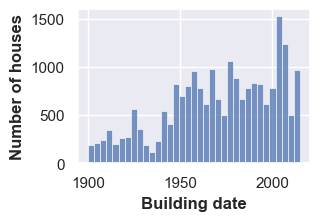

In [14]:
# Building dates
sns.set_theme(rc={'figure.figsize':(3,2)})
ax = sns.histplot(df_short, x="yr_built")
plt.xlabel("Building date",weight="bold")
plt.ylabel("Number of houses",weight="bold")


Text(0, 0.5, 'Selling price')

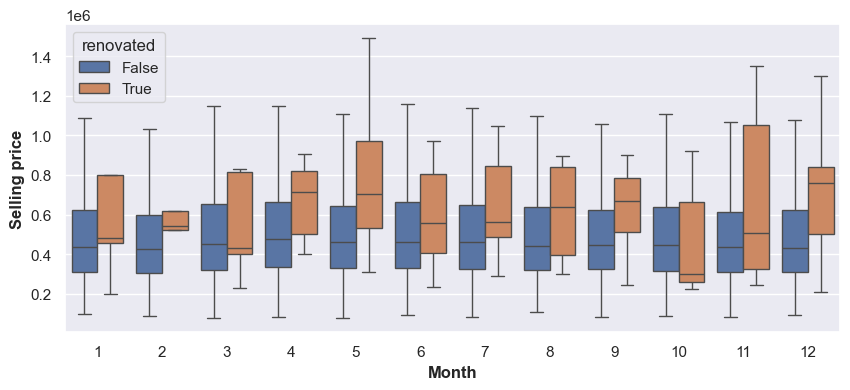

In [15]:
# General selling prices over months
sns.set_theme(rc={'figure.figsize':(10,4)})
sns.boxplot(df_short, x="date_month",y="price",hue="renovated", showfliers=False)
plt.xlabel("Month",weight="bold")
plt.ylabel("Selling price",weight="bold")

This graphic shows that buying unrenovated houses and renovate them would make a lot of profit.
Espacially, selling in summer would be great.
February and november (Winter) are good times to buy beacuse there the houses are a bit cheaper

/var/folders/0y/y6rj9tc5707_6x_j9g93bp200000gn/T/ipykernel_1060/299312064.py:3: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




Text(0, 0.5, 'Selling price')

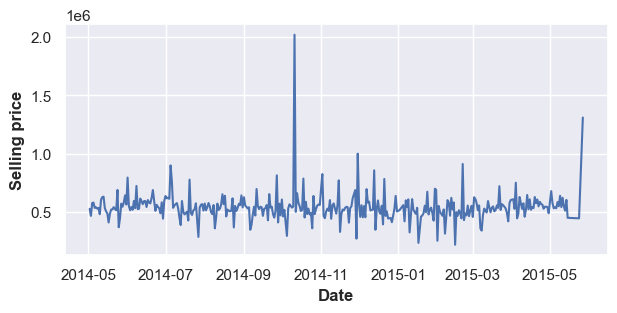

In [355]:
# General selling prices over the years
sns.set_theme(rc={'figure.figsize':(7,3)})
sns.lineplot(df_short, x="date",y="price",ci=None)
plt.xlabel("Date",weight="bold")
plt.ylabel("Selling price",weight="bold")

<Axes: xlabel='date_month', ylabel='Count'>

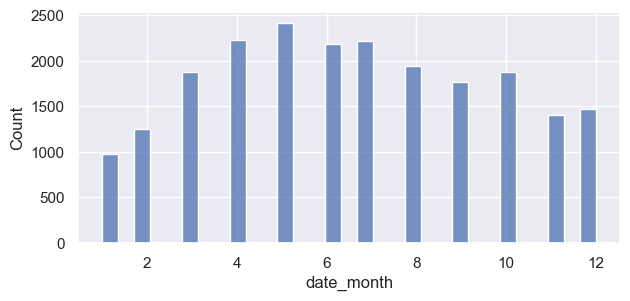

In [356]:
# How many houses have been sold by month
sns.histplot(df_short,x="date_month")

In [357]:
# Geographical map of King County and all houses (best neighborhoods are colored)
color_cond="zip"

fig1 = px.scatter_map(df_short, #our dataframe
                      lat=df_short['lat'], #set latitudes
                      lon=df_short['long'], #set longitudes
                      width=600,
                      height=800,
                      color=f"cond_neighbor_{color_cond}",
                      color_discrete_map={False: 'gray', True: 'orange'},
                      #hover_name = 'name', #set the name that appears when hovering with the cursor over the dots
                      hover_data={'lat':False, 'long':False}, #sets additional hovering data (latitude and longitude is True by default)
                      center = {"lat": 47.477912, "lon": -122.106530}, #this sets the center of the US as initial map center
                      zoom =9, #initial zoom level
                      color_discrete_sequence=["black"]) #color of the dots

fig1.show()

In [358]:
# Create the month/price histogram depended on different features (house footage, lot footage, grade, condition, view, etc.)

def price_by_month(features,title, dataset=df_best):
    df_featured = dataset
    for feature,quantile in features.items():
        df_featured = df_featured[df_featured[feature] > df_featured[feature].quantile(quantile)]


    sns.set_theme(rc={'figure.figsize':(10,4)})
    sns.boxplot(df_featured, x="date_month",y="price",hue="renovated", showfliers=False)
    plt.title(title,weight="bold")
    plt.xlabel("Month",weight="bold")
    plt.ylabel("Selling price",weight="bold")
    plt.show()

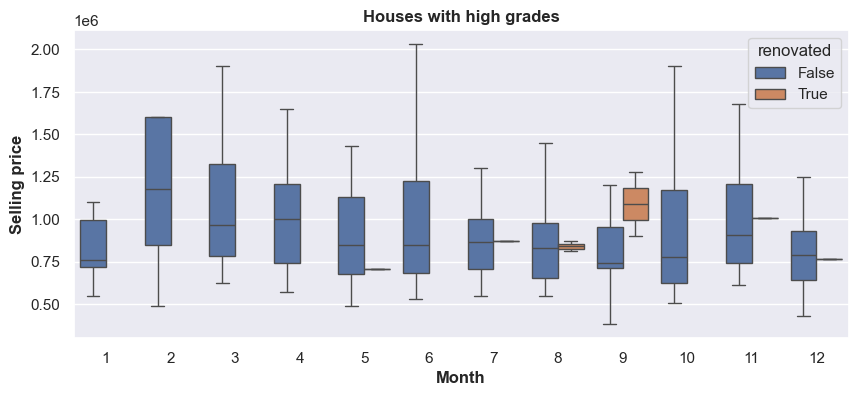

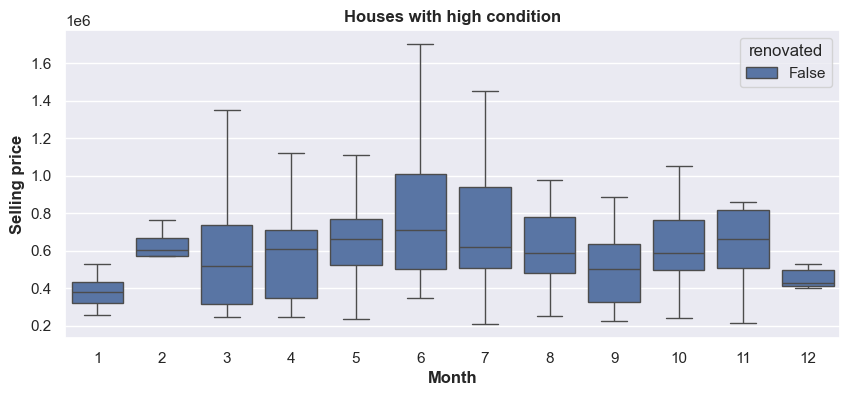

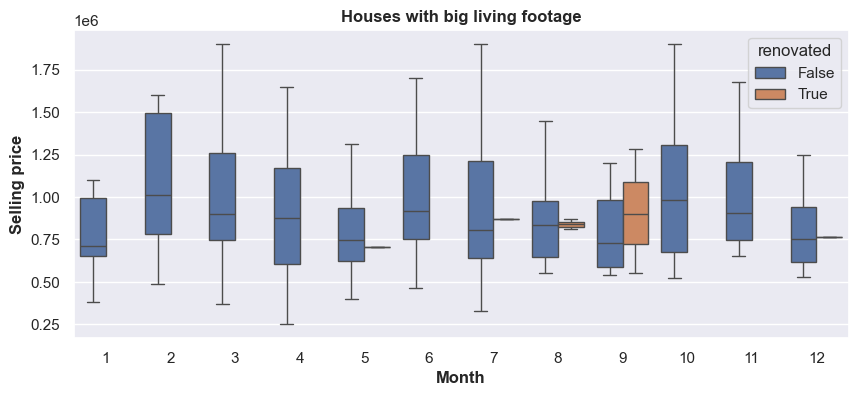

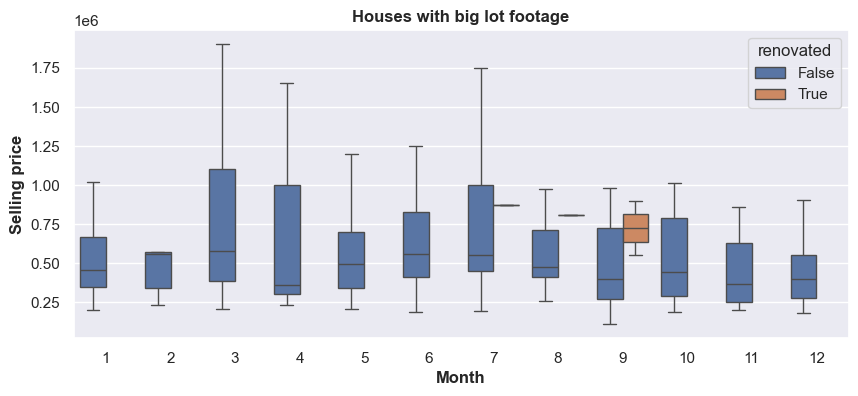

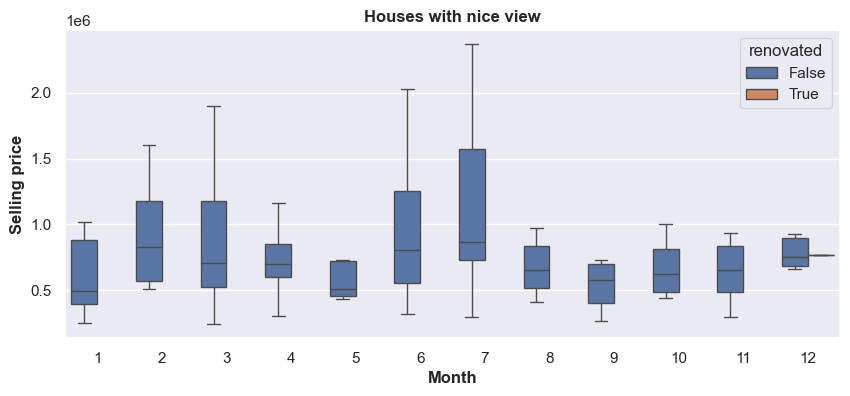

In [359]:
price_by_month({"grade":0.75},"Houses with high grades", dataset=df_best)
price_by_month({"condition":0.75},"Houses with high condition", dataset=df_best)
price_by_month({"sqft_living":0.75},"Houses with big living footage", dataset=df_best)
price_by_month({"sqft_lot":0.75},"Houses with big lot footage", dataset=df_best)
price_by_month({"view":0.75},"Houses with nice view", dataset=df_best)

## Result

We take only houses which fulfill all these conditions:
- built before 1949 (historical)
- ZIP codes given by ChatGPT (best neighborhoods)
- grade > 9
- view > 2
- sqft_living is bigger than 50%

In [360]:
df_final = df_best[(df_best["grade"]>9) & (df_best["view"]>2) & (df_best["sqft_living"]>df_best["sqft_living"].mean())]
df_final

,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,long,sqft_living15,sqft_lot15,sale_id,date,price,date_month,renovated,cond_neighbor_liv,cond_neighbor_zip
1768,625059051,4.0,2.25,4370.0,22863.0,2.5,0.0,3.0,4,10,...,-122.215,2980.0,22863.0,1769,2014-09-03,2350000.0,9,False,False,True
3582,9272200090,4.0,4.50,3780.0,6000.0,2.0,0.0,4.0,4,11,...,-122.388,2660.0,6000.0,3583,2015-02-04,1600000.0,2,False,False,True
4631,1324049015,4.0,2.50,3440.0,23954.0,1.5,1.0,3.0,5,10,...,-122.231,4230.0,18723.0,4632,2014-11-11,2490000.0,11,False,True,True
7245,6762700020,6.0,8.00,12050.0,27600.0,2.5,0.0,3.0,4,13,...,-122.323,3940.0,8800.0,7246,2014-10-13,7700000.0,10,False,True,True
7879,3024059014,4.0,2.25,3020.0,11489.0,1.5,1.0,3.0,5,10,...,-122.210,3890.0,11489.0,7880,2015-03-25,1900000.0,3,False,True,True
8775,3343302110,3.0,3.00,2790.0,13295.0,2.0,1.0,4.0,4,10,...,-122.197,3140.0,11949.0,8776,2015-03-06,1800000.0,3,False,False,True
10847,3505100126,3.0,3.00,3760.0,8500.0,2.5,0.0,3.0,4,10,...,-122.398,2610.0,5500.0,10848,2014-06-26,1250000.0,6,False,False,True
13620,3528900401,3.0,3.25,3140.0,5445.0,2.0,0.0,3.0,4,10,...,-122.347,2950.0,5250.0,13621,2014-07-01,1640000.0,7,False,False,True
17966,46100504,4.0,3.75,4100.0,22798.0,1.5,NaN,3.0,5,11,...,-122.210,3880.0,18730.0,17967,2014-06-17,2030000.0,6,False,True,True
18753,1959701800,3.0,3.50,4660.0,5500.0,2.0,0.0,4.0,5,10,...,-122.319,2980.0,5500.0,18754,2014-07-02,2150000.0,7,False,False,True


In [361]:

fig1 = px.scatter_map(df_final, #our dataframe
                      lat=df_final['lat'], #set latitudes
                      lon=df_final['long'], #set longitudes
                      width=600,
                      height=800,
                      hover_data={'lat':False, 'long':False}, #sets additional hovering data (latitude and longitude is True by default)
                      center = {"lat": 47.632796, "lon": -122.260953}, #this sets the center of the US as initial map center
                      zoom =10, #initial zoom level
                      color_discrete_sequence=["black"]) #color of the dots

fig1.show()

In [362]:
# Historical houses locations

conditions = [(df_short["yr_built"]<=1949) & (df_short["yr_built"]>1924),
              df_short["yr_built"]<=1924,
              df_short["yr_built"]>1949]
choices = ["Built before 1949", "Built before 1924", "Built after 1949"]

df_short['house_age'] = np.select(conditions, choices, default='null')

fig1 = px.scatter_map(df_short, #our dataframe
                      lat=df_short['lat'], #set latitudes
                      lon=df_short['long'], #set longitudes
                      color="house_age",
                      color_discrete_map={"Built after 1949": 'gray', "Built before 1949": 'orange', "Built before 1924": 'red'},
                      width=600,
                      height=800,
                      hover_data={'lat':False, 'long':False}, #sets additional hovering data (latitude and longitude is True by default)
                      center = {"lat": 47.492796, "lon": -122.190953}, #this sets the center of the US as initial map center
                      zoom =9, #initial zoom level
                      color_discrete_sequence=["black"]) #color of the dots

fig1.show()